In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# if you need to use GPU accelerated simulation:
# dev = qml.device("lightning.gpu", wires=k)

In [3]:
def prepare_random_state(a, b, c):
    qml.RX(a, wires=0)
    qml.RY(b, wires=0)
    qml.RZ(c, wires=0)

## Three-qubit bit flip error correction code with conventional error correction algorithm

<img src="img/Quantum_error_correction_of_bit_flip_using_three_qubits.png" width="800px"> 

In [4]:
def simulate_three_qubit_flip(p, wires):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[0], wires[2]])

    # simulate bit flip error on the qubits
    qml.BitFlip(p, wires=wires[0])
    qml.BitFlip(p, wires=wires[1])
    qml.BitFlip(p, wires=wires[2])


In [5]:
# Three-qubit bit flip code without QAE for benchmark

dev = qml.device("default.mixed", wires=3)
@qml.qnode(dev)
def ground_truth_three_qubit(a, b, c):
    prepare_random_state(a, b, c)
    return qml.probs(wires=0)


@qml.qnode(dev)
def qec_three_qubit_flip(p, a, b, c):
    prepare_random_state(a, b, c)
    
    simulate_three_qubit_flip(p, [0,1,2])
    # error correction circuit
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.Toffoli(wires=[1,2,0])
    return qml.probs(wires=0)

print(ground_truth_three_qubit(0.1, 0.2, 0.3))
print(qec_three_qubit_flip(0.3, 0.1, 0.2, 0.3))

[0.98758516 0.01241484]
[0.77694837 0.22305163]


## General encoder decoder architecture setup

In [ ]:
def encoder(weights, wires):
    # encoder reduces the information from three qubits into latent space of one qubit
    # parameters are a, b, and, c which we will tune using gradient descent
    # three qubit
    qml.ArbitraryUnitary(weights, wires=wires)

decoder = qml.adjoint(encoder)

## three-qubit QAE

<img src="img/3_qubit_qnn.png" width="300px"> 

ground truth for three qubit 

In [6]:
@qml.qnode(dev)
def qae_ground_truth_three_qubit(state):
    prepare_random_state(state[0], state[1], state[2])
    
    qml.CNOT(wires=[0, 1]) # copy from 0 to 1
    qml.CNOT(wires=[0, 2]) # copy from 0 to 2

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

0.2662129960442969


In [ ]:
# Three-qubit QAE
dev = qml.device("default.mixed", wires=7)
@qml.qnode(dev)
def three_qubit_qae(state, weights):    
    prepare_random_state(state[0], state[1], state[2])
    simulate_three_qubit_flip(p, [0,1,2])


    encoder(weights, [0, 1, 2, 3])

    decoder(weights, [4, 5, 6, 3])
    
    return qml.expval(qml.PauliZ(4) @ qml.PauliZ(5) @ qml.PauliZ(6))

loss function for three qubit QAE

In [ ]:
n_samples= 100
state = np.random.rand(3)
p = 0.1
X = np.random.randn(n_samples, 3)

# 3-qubit weights shape: 4 ^ 4 -1 = 255
weights = np.random.randn(4**4-1, requires_grad=True)

def loss_three_qubit_qae(weights):
    loss_sum = 0.0
    for idx in range(n_samples):
        state = X[idx]
        true_expval = qae_ground_truth_three_qubit(state)
        estimated_expval = three_qubit_qae(state, weights)
        loss_sum += (estimated_expval - true_expval) ** 2
    return loss_sum / n_samples




#print(three_qubit_qae(p, state, weights))
print(loss_three_qubit_qae(weights))

let's train the three-qubit QAE

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


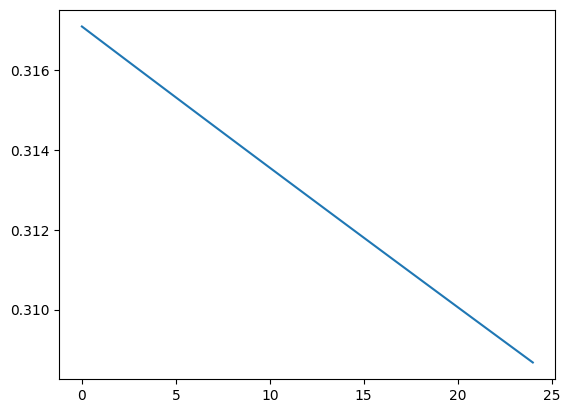

In [90]:
theta = np.array(0., requires_grad=True)
phi = np.array(0., requires_grad=True)

opt = qml.GradientDescentOptimizer()

num_its = 25
running_costs = []

for i in range(num_its):
    weights, _cost = opt.step_and_cost(loss_three_qubit_qae, weights)
#     (theta, phi, zeta), _cost = opt.step_and_cost(circuit, theta, phi, zeta)
    running_costs.append(_cost)
    print(i)

plt.plot(running_costs)


## Five qubit code stabilizer measurement circuit


<img src="img/Five_qubit_code_stabilizer_measurement_circuit.png" width="800px"> 

In [ ]:
@qml.qnode(dev)
def qae_ground_truth_five_qubit(state):
    prepare_random_state(state[0], state[1], state[2])
    
    qml.CNOT(wires=[0, 1]) # copy from 0 to 1
    qml.CNOT(wires=[0, 2]) # copy from 0 to 2
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 4])

    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3) @ qml.PauliZ(4))

In [ ]:
# type needs to be one of "X", "Y", "Z"
def simulate_5_qubit_flip(type, p, wires):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.CNOT(wires=[wires[0], wires[4]])

    # simulate bit flip error on the qubits
    if (type == "X" or type == "Y" or type == "Z"):
        qml.PauliError(type, p, wires=wires[0])
        qml.PauliError(type, p, wires=wires[1])
        qml.PauliError(type, p, wires=wires[2])
        qml.PauliError(type, p, wires=wires[3])
        qml.PauliError(type, p, wires=wires[4])
    else:
        print("Please enter an valid type for Pauli Error in function simulate_5_qubit_flip")

In [ ]:
# Five-qubit QAE
errorType = "X"

dev = qml.device("default.mixed", wires=11)
@qml.qnode(dev)
def five_qubit_qae(state, weights):    
    prepare_random_state(state[0], state[1], state[2])
    simulate_5_qubit_flip(errorType, p, [0,1,2,3,4])

    encoder(weights, [0, 1, 2, 3, 4, 5])

    decoder(weights, [6, 7, 8, 9, 10, 5])
    
    return qml.expval(qml.PauliZ(6) @ qml.PauliZ(7) @ qml.PauliZ(8) @ qml.PauliZ(9)  @ qml.PauliZ(10))

In [ ]:
n_samples= 100
state = np.random.rand(3)
p = 0.1
X = np.random.randn(n_samples, 3)

# 5-qubit weights shape: 4 ^ 6 -1 = 4095
weights = np.random.randn(4**6-1, requires_grad=True)

def loss_five_qubit_qae(weights):
    loss_sum = 0.0
    for idx in range(n_samples):
        state = X[idx]
        true_expval = qae_ground_truth_five_qubit(state)
        estimated_expval = five_qubit_qae(state, weights)
        loss_sum += (estimated_expval - true_expval) ** 2
    return loss_sum / n_samples

print(loss_five_qubit_qae(weights))

In [ ]:
# https://arxiv.org/abs/quant-ph/9705052